# L2c: Singular Value Decomposition of Systems and Data
In this lecture, we'll continue our discussion of eigendecomposition and explore a powerful technique called [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition), which is closely related to eigendecomposition. There are several key ideas in this lecture:

* __Singular Value Decomposition (SVD)__ is a fundamental technique in linear algebra that decomposes a matrix $\mathbf{A}\in\mathbb{C}^{n\times{m}}$ into three distinct matrices, $\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\top}$. The matrices $\mathbf{U}$ and $\mathbf{V}$  are orthogonal matrices containing the left and right singular vectors, respectively, while the $\mathbf{\Sigma}$ is a diagonal matrix containing the singular values.
* __Singular vectors__ contained in the columns of the $\mathbf{U}$ and $\mathbf{V}$ are the eigenvectors of the matrix product $\mathbf{A}\mathbf{A}^{\top}$ and $\mathbf{A}^{\top}\mathbf{A}$, respectively. In cases where $\mathbf{A}$ is symmetric (square) and positive definite (positive eigenvalues), the left and right singular vectors align with the eigenvectors.
* __Singular values__ of a matrix $\mathbf{A}$ are the square roots of the non-zero eigenvalues of either $\mathbf{A}\mathbf{A}^{\top}$ or $\mathbf{A}^{\top}\mathbf{A}$, establishing a direct connection between these two values. In cases where $\mathbf{A}$ is symmetric (square) and positive definite (positive eigenvalues), the singular values correspond directly to the absolute values of the eigenvalues.
* __Numerical Stability__. SVD is more stable than eigendecomposition, especially in Principal Component Analysis (PCA), making it preferable for machine learning applications. Many SVD implementations are more stable than the naive QR iteration method we developed for eigendecomposition.

Lecture notes can be found: [here!](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-2/L2c/docs/Notes.pdf)

## Setup, Data and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [229]:
include("Include.jl");

### Data
In this lecture, we'll consider two example datasets. First, we'll look at the decomposition of an image, particularly a gray-scale image 
frame taken from a complex system simulation, and the second a stoichiometric matrix for a human red blood cell.

First, we load the image frame data from disk (we saved a few frames in [a `JLD2` binary file](https://github.com/JuliaIO/JLD2.jl)), we store this data in the `frames::Dict{Int, Array{Int,2}}` dictionary (we'll also load some `colors::Dict{Int16, RGB}` that we'll use for visualization).

In [231]:
frames, colors = let

    # initialize some storage
    frames = Dict{Int, Array{Int,2}}();

    # load saved simulation data
    saveddata = load(joinpath(_PATH_TO_DATA, "L2c-SavedData-CHEME-5820-S2025.jld2"))
    colors = saveddata["colors"];

    # package up the frames -
    frames[0] = saveddata["startframe"];
    frames[1] = saveddata["middleframe"];
    frames[2] = saveddata["endframe"];

    frames, colors # return this data
end;

In [232]:
frames[1]

256×256 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  0  0  0  0  0  0  0  0  2  2  1  1     0  0  0  0  0  1  0  0  0  0  0  1
 1  0  2  1  0  1  0  2  2  2  0  0  1     1  1  0  1  2  2  2  0  0  0  0  1
 1  0  1  0  2  0  0  1  0  0  0  1  0     2  0  1  1  1  2  1  0  1  1  0  1
 1  1  0  2  2  1  2  2  0  0  0  2  1     1  2  0  1  2  0  1  0  1  0  0  1
 1  0  2  0  1  1  2  1  0  2  0  0  0  …  2  0  2  1  1  2  0  0  0  2  0  1
 1  0  0  0  1  0  2  0  2  0  0  0  0     0  2  2  2  1  2  1  1  1  0  0  1
 1  2  0  0  0  2  1  0  0  0  0  1  0     2  0  1  2  2  1  2  1  2  0  0  1
 1  0  2  0  1  1  0  0  0  0  1  0  0     2  2  0  1  0  2  2  2  0  0  0  1
 1  0  0  1  0  1  2  0  0  0  2  0  0     2  0  1  2  1  0  1  1  1  0  0  1
 1  0  0  1  1  2  0  2  0  2  0  2  0  …  1  2  0  1  0  0  0  0  0  0  2  1
 1  0  1  0  2  0  2  0  0  0  0  0  0     0  0  1  0  0  0  2  2  0  0  0  1
 1  1  0  2  0  2  1  1  1  0  0  1  1   

Next, we'll load data for the `iAB_RBC_283` model of the metabolism of a human red blood cell; see the paper for details:
* [Bordbar, A., Jamshidi, N. & Palsson, B.O. iAB-RBC-283: A proteomically derived knowledge-base of erythrocyte metabolism that can be used to simulate its physiological and patho-physiological states. BMC Syst Biol 5, 110 (2011). https://doi.org/10.1186/1752-0509-5-110](https://rdcu.be/d7NVm)

The data for the model is stored in the `model::Dict{String, Any}` variable, we'll use this data to create the stoichiometric matrix.

In [234]:
model = let

    modelid = "iAB_RBC_283"; # model id to download
    path_to_saved_model_file = joinpath(_PATH_TO_DATA, "saved-model-$(modelid).jld2");
    model = load(path_to_saved_model_file)["model"];

    model
end

Dict{String, Any} with 6 entries:
  "metabolites"  => Any[Dict{String, Any}("compartment"=>"c", "name"=>"3-Phosph…
  "id"           => "iAB_RBC_283"
  "compartments" => Dict{String, Any}("c"=>"cytosol", "e"=>"extracellular space…
  "reactions"    => Any[Dict{String, Any}("name"=>"Sink pchol hs 18 1 18 1(c)",…
  "version"      => "1"
  "genes"        => Any[Dict{String, Any}("name"=>"NMRK1", "id"=>"Nrk1_AT1", "n…

__Stoichiometric matrix__: We can build the stoichiometric matrix $\mathbf{S}\in\mathbb{R}^{|\mathcal{M}|\times|\mathcal{R}|}$ for the `iAB_RBC_283` model using the `metabolite` and `reaction` records from `model::Dict{String, Any}.` We'll do this using two [`for` loops](https://docs.julialang.org/en/v1/base/base/#for). 
* __Strategy__: In the outer loop, we iterate over the system's metabolites (chemical species) and select the `id` from the metabolites record for each metabolite. In the inner loop, we iterate over each reaction. For each reaction record, we ask if this reaction has an entry for the current metabolite `id` value; if it does, we grab the stoichiometric coefficient $\sigma_{ij}$ corresponding to this metabolite and reaction.

In [236]:
S = let

    # get some data from the model -
    m = model["metabolites"]; # get list of metabolites
    r = model["reactions"]; # get list of reactions
    number_of_rows = length(m); # how many metabolites do we have? (rows)
    number_of_cols = length(r); # how many reactions do we have? (cols)
    S = zeros(number_of_rows,number_of_cols); # initialize an empty stoichiometric matrix

    # let's build a stm -
    for i ∈ eachindex(m)
        metabolite = m[i]["id"]; # we are checking if this metabolite is in the reaction record
        for j ∈ eachindex(r)
            reaction = r[j];
            if (haskey(reaction["metabolites"], metabolite) == true)
                S[i,j] = reaction["metabolites"][metabolite];
            end
        end
    end
    S; 
end;

### Constants
Let's set some constants from the saved data. For what the constant does, it's permissible values, units, etc see the comments.

In [238]:
width = frames[0] |> x-> size(x, 2) # cols
height = frames[0] |> x-> size(x, 1) # rows
number_of_agents = width*height;
radius = 4; # either {4 | 8} for 2D (so far)
number_of_colors = 3; # number of states
number_of_excluded_points = 0; # how many points should we add to the exclude set

## Theory: Singular value decomposition factors a matrix into rank one blocks
Let the matrix $\mathbf{A}\in\mathbb{R}^{m\times{n}}$ be some rectangular matrix. The singular value decomposition of the matrix $\mathbf{A}$ given $\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\top}$ is a tool to _factor_ the matrix $\mathbf{A}$ into components, each with a different amount of information. Thus, the matrix is _telling us_ what is important, we just need to listen!
* The matricies $\mathbf{U}\in\mathbb{R}^{n\times{n}}$ and $\mathbf{V}\in\mathbb{R}^{m\times{m}}$ are _orthogonal matrices_ that hold the of the matrix product $\mathbf{A}\mathbf{A}^{\top}$ and $\mathbf{A}^{\top}\mathbf{A}$, respectively. The columns of $\mathbf{U}$ are called left-singular vectors, while the columns of $\mathbf{V}$ are called right-singular vectors. Singular vectors have a unique property: left- and right-singular vectors are orthogonal.
* The matrix $\mathbf{\Sigma}\in\mathbb{R}^{n\times{m}}$ is a diagonal matrix containing the singular values $\sigma_{i}=\Sigma_{ii}$ along the main diagonal. The singular values are the square roots of the eigenvalues of the matrix $\mathbf{A}^{\top}\mathbf{A}$.

#### Why is this interesting?
Singular value decomposition can be thought of as decomposing a matrix into a weighted, ordered sum of separable matrices, e.g., frames of a larger image, where each component has rank `1`. Let $\mathbf{A}\in\mathbb{R}^{m\times{n}}$ have the singular value decomposition $\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\top}$. Then, the matrix $\mathbf{A}\in\mathbb{R}^{m\times{n}}$ can be written as:
$$
\mathbf{A} = \sum_{i=1}^{r_{\mathbf{A}}}\sigma_{i}\cdot\left(\mathbf{u}_{i}\otimes\mathbf{v}_{i}\right)
$$
where $r_{\mathbf{A}}$ is the rank of matrix $\mathbf{A}$, the vectors $\mathbf{u}_{i}$ and $\mathbf{v}_{i}$ are the ith left and right singular vectors, and $\sigma_{i}$ are the ordered singular values. The [outer-product](https://en.wikipedia.org/wiki/Outer_product) $\left(\mathbf{u}_{i}\otimes\mathbf{v}_{i}\right)$ is the separable component of the matrix $\mathbf{A}$ with rank `1`.

## Example 1: Decompose of Wolfram Two-Dimensional Cellular Automata Frame
In this example, we'll decompose a frame from [a two-dimensional Wolfram-style totalistic cellular automata](https://en.wikipedia.org/wiki/Cellular_automaton) simulation, in which a 256$\times$256 rectangular grid of agents use a combination of rules to update their state $s$ (based on their neighbor's state) to one of three possible states $s\in\{0,1,2\}$. For more information on this type of simulation, see:
* [Packard, Norman H. and Stephen Wolfram. “Two-dimensional cellular automata.” Journal of Statistical Physics 38 (1985): 901-946.](https://doi.org/10.1007/BF01010423)

What's in a frame?

In [241]:
f = frames[1]; # let's use the middle frame

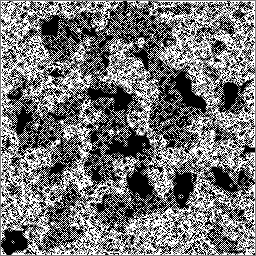

In [242]:
display_frame = let
    frame_to_visualize = f; # the frame we want to visualize
    my_color_dictionary = colors;
    number_of_rows = height;
    number_of_columns = width;
    new_display_frame = Array{RGB,2}(undef, number_of_rows, number_of_columns);
    for j ∈ 1:number_of_rows
        for k ∈ 1:number_of_columns
            new_display_frame[j,k] = frame_to_visualize[j,k] |> s -> my_color_dictionary[s];
        end
    end
    new_display_frame
end

In [243]:
(U,Σ,VT) = let

    img = f .|> Float64 # convert the frame to Float, before we decompose
    (U,Σ,VT) = svd(img); # compute the SVD of the frame at index i

    U,Σ,VT
end;

#### Not every sub-image contains the same amount of information
One of the cool things about [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) is that `modes` are sorted and weighted by the singular values. Thus, we can compute the contribution of each `mode` by looking at the singular values.
* Let's compute and visualize how much information, i.e., what fraction of the original image is explained by each `mode,` by looking at the cumulative fraction of the data explained. For example, the first `125` modes explain approximately `80%` of the data in the image.

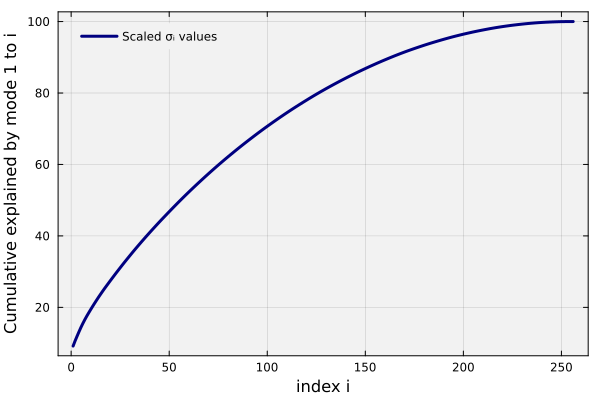

In [245]:
let
    # make a plot of the fractional contribution of the singular values
    number_of_modes = length(Σ);
    ΣS = (1/sum(Σ))*Σ;
    explained_array = [100*sum(ΣS[1:i]) for i ∈ 1:number_of_modes]; # comprehension

    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    plot!(explained_array, label="Scaled σᵢ values", lw=3, c=:navy)
    xlabel!("index i", fontsize=18)
    ylabel!("Cumulative explained by mode 1 to i", fontsize=18)
end

### Compute the sub-images and store them in a dictionary
Let's compute the weighted [outer product](https://en.wikipedia.org/wiki/Outer_product) for each mode, i.e, the $\sigma_{i}\cdot\left(\mathbf{u}_{i}\otimes\mathbf{v}_{i}\right)$ terms and store them in the `image_dictionary::Dict{Int64,Matrix{Float64}}` variable. 
* __Fancy syntax__: This code block uses [the `for each (...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.foreach), which is an iteration pattern that calls a function `f` on each element of the iterable collection `c.` TLDR: a one-line for-loop.

In [247]:
R = rank(f); # how many frames will we have?
image_dictionary = Dict{Int64,Matrix{Float64}}();
foreach(i -> image_dictionary[i] = Σ[i]*outer(U[:,i],VT[:,i]), 1:R); # another iteration pattern???

Let's visualize the modes stored in the `image_dictionary::Dict{Int64,Matrix{Float64}}`:

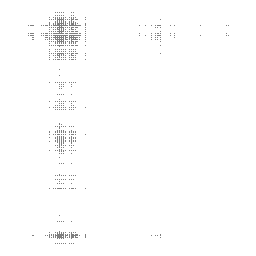

In [249]:
let
    reconstructed_image = image_dictionary[4];
    frame_to_visualize = reconstructed_image .|> x-> Int(round(abs(x))) # convert back to Int
    my_color_dictionary = colors;
    
    number_of_rows = height;
    number_of_columns = width;
    new_display_frame = Array{RGB,2}(undef, number_of_rows, number_of_columns);
    for j ∈ 1:number_of_rows
        for k ∈ 1:number_of_columns
            value = frame_to_visualize[j,k];
            if (value > 2)
                value = 2;
            end
            new_display_frame[j,k] = value |> s -> my_color_dictionary[s];
        end
    end
    new_display_frame
end

### Can you reconstruct the original image by adding up all the sub-images?
Let's try to rebuild the original image by `adding up` the sub-images. 
* Grab the first `frame` from the `image_dictionary` and set this to the `reconstructed_image` variable. Then, iterate through the collection up to a specified `number_of_frames` of frames, where we update the `reconstructed_image` variable each time through the loop.
* __Technical issue__: The states $s$ in the cellular automata simulation are integers, but the SVD is a floating point operation (and the saved image modes of floating point). Thus, we convert every element back to [an `Int`](https://docs.julialang.org/en/v1/base/numbers/#Core.Int) by taking the absolute value (get's rid of small negative values) and using [the `round(...)` function](https://docs.julialang.org/en/v1/base/math/#Base.round) to convert back to [an `Int`](https://docs.julialang.org/en/v1/base/numbers/#Core.Int) type.

In [251]:
M = let
    reconstructed_image = image_dictionary[1];
    number_of_frames = 50;
    for i ∈ 2:number_of_frames
        reconstructed_image += image_dictionary[i];
    end
    reconstructed_image .|> x-> Int(round(abs(x))) # convert back to Int
end

256×256 Matrix{Int64}:
 1  0  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  0  1
 0  0  1  0  0  0  0  1  0  1  1  0  0     0  0  0  0  0  1  0  0  0  1  0  0
 1  0  1  0  0  1  0  1  1  1  1  0  1     1  1  0  1  1  2  2  1  1  1  0  1
 1  0  1  1  2  0  0  1  0  0  1  1  0     2  0  2  1  1  2  1  1  1  1  1  1
 1  1  0  1  1  1  2  2  1  0  0  2  1     1  2  0  2  1  1  2  0  1  0  0  1
 1  0  2  0  1  1  2  1  1  1  1  1  1  …  3  1  1  1  1  1  1  0  1  2  0  1
 1  0  0  0  0  0  1  1  2  0  0  1  1     1  2  1  2  1  2  1  1  1  1  0  1
 1  1  0  0  0  1  1  1  1  1  0  0  0     3  0  1  1  2  1  1  1  2  0  0  1
 1  0  2  0  1  1  0  0  0  0  0  1  0     0  2  0  1  0  2  1  2  0  0  0  1
 1  0  0  0  1  1  2  1  1  0  1  1  1     1  1  1  2  1  1  1  1  0  1  0  1
 1  0  0  1  2  2  0  2  1  2  1  2  0  …  1  2  0  1  1  1  0  1  0  0  1  1
 1  0  1  0  1  0  1  1  1  0  0  0  1     1  0  1  0  1  0  2  2  1  1  0  1
 1  1  1  1  1  2  1  0  1  1  0  1  0   

`Unhide` the code block below to see how we visualized the _reconstructed_ simulation frame. 

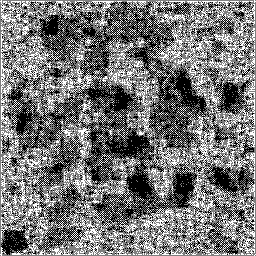

In [253]:
let
    frame_to_visualize = M;
    my_color_dictionary = colors;
    number_of_rows = height;
    number_of_columns = width;
    new_display_frame = Array{RGB,2}(undef, number_of_rows, number_of_columns);
    for j ∈ 1:number_of_rows
        for k ∈ 1:number_of_columns
            value = frame_to_visualize[j,k];
            if (value > 2)
                value = 2;
            end
            new_display_frame[j,k] = value |> s -> my_color_dictionary[s];
        end
    end
    new_display_frame
end

## Example 2: Let's pull apart a stochiometric matrix using SVD
The second example we'll look at is the decomposition of a stoichiometric matrix using [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition). The reaction network that we'll explore in the [Human Red Blood cell network developed by Palsson and coworkers](https://rdcu.be/d7NVm)

#### Background
Suppose we have a set of chemical (or biochemical) reactions $\mathcal{R}$ involving the chemical species (metabolite) set $\mathcal{M}$. Then, the stoichiometric matrix is a $\mathbf{S}\in\mathbb{R}^{|\mathcal{M}|\times|\mathcal{R}|}$ matrix that holds the stoichiometric coefficients $\sigma_{ij}\in\mathbf{S}$ such that:
* $\sigma_{ij}>0$: Chemical species (metabolite) $i$ is _produced_ by reaction $j$. Species $i$ is a product of reaction $j$.
* $\sigma_{ij} = 0$: Chemical species (metabolite) $i$ is not connected with reaction $j$
* $\sigma_{ij}<0$: Chemical species (metabolite) $i$ is _consumed_ by reaction $j$. Species $i$ is a reactant of reaction $j$.

In [276]:
S # constructed for the RBC model

342×469 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [272]:
(U2,Σ2,VT2) = svd(S); # compute the SVD of the stochiomertric matrix

In [294]:
subsystems_dictionary = let

    R = rank(S); # how many frames will we have?
    subsystem_dictionary = Dict{Int64,Matrix{Float64}}();
    foreach(i -> subsystem_dictionary[i] = Σ2[i]*outer(U2[:,i],VT2[:,i]), 1:R); # another iteration pattern???
    subsystem_dictionary;
end;

In [300]:
subsystems_dictionary[3]

342×469 Matrix{Float64}:
 -3.75858e-6   -3.53993e-6   -3.53993e-6   …  -0.00303358   -0.00303358
  2.02088e-6    1.90332e-6    1.90332e-6       0.00163107    0.00163107
  3.01662e-6    2.84113e-6    2.84113e-6       0.00243474    0.00243474
  6.94264e-7    6.53876e-7    6.53877e-7       0.000560347   0.000560347
  3.57866e-6    3.37048e-6    3.37048e-6       0.00288837    0.00288837
  4.38774e-6    4.13249e-6    4.1325e-6    …   0.00354139    0.00354139
  2.94509e-5    2.77377e-5    2.77377e-5       0.0237701     0.0237701
  5.01068e-6    4.71919e-6    4.71919e-6       0.00404416    0.00404416
  4.29746e-6    4.04746e-6    4.04746e-6       0.00346851    0.00346851
  1.4119e-6     1.32977e-6    1.32977e-6       0.00113956    0.00113956
  1.04448e-6    9.83717e-7    9.83717e-7   …   0.000843007   0.000843007
  6.95707e-7    6.55236e-7    6.55236e-7       0.000561511   0.000561511
  2.42357e-6    2.28259e-6    2.28259e-6       0.00195609    0.00195609
  ⋮                                  

## Today?
That's a wrap! What are three things we discussed today?